In [1]:
import sys
sys.path.append('../')

import numpy as np
import numba as nb
import matplotlib.pyplot as plt
import pandas as pd
from particle_filter import particlefilter
from pmcmc import particlemcmc
from math_utils import nbinom_logpmf

In [2]:
'''Import data'''

data = pd.read_csv('..\\data_sets\\ou_data_nbinom.csv').to_numpy()
state = pd.read_csv('..\\data_sets\\ou_state_nbinom.csv').to_numpy()
betas = pd.read_csv('..\\data_sets\\ou_betas_nbinom.csv').to_numpy()

In [3]:
def SEIR_model(particles,observations,t,dt,model_params,rng):
    '''Definition of SEIR model as described in Calvetti's paper. Difference 
    is the use of Tau leaping to introduce stochasticity into the system and continuous log-normal OU process definition for beta.'''
    gamma,sig,mu,lam,_ = model_params

    A = np.exp(-lam * dt)
    M = mu * (np.exp(-lam * dt) - 1)
    C = sig * np.sqrt(1 - np.exp(-2 * lam * dt))

    '''Tau leaping. Non estimated parameters are hard coded. '''

    for index in range(particles.shape[0]):

        new_E = rng.poisson((particles[index,4,t] * (particles[index, 1, t] + 0.1 * particles[index, 2, t]) * particles[index, 0, t])/np.sum(particles[index,:,t]) * dt)
        new_I = rng.poisson((1/7 * particles[index,1,t]) * dt)
        new_ER = rng.poisson((gamma * particles[index,1,t]) * dt)
        new_IR = rng.poisson((gamma * particles[index,2,t]) * dt)
        new_D = rng.poisson((0.004 * particles[index,2,t]) * dt)

        particles[index,0,t] = np.maximum(0.,particles[index,0,t] - new_E) #S
        particles[index,1,t] = np.maximum(0.,particles[index,1,t] + new_E - new_I - new_ER) #E
        particles[index,2,t] = np.maximum(0.,particles[index,2,t] + new_I - new_IR - new_D) #I
        particles[index,3,t] = np.maximum(0.,particles[index,3,t] + new_ER + new_IR)
        particles[index,4,t] = np.exp(A * np.log(particles[index,4,t]) - M + C * rng.standard_normal())

        observations[index,0,t] = particles[index,2,t]

    return particles,observations

def SEIR_Obs(data_point, particle_observations, model_params):
    r = 1/model_params[4]
    weights = nbinom_logpmf(x = data_point,p = r/(r + particle_observations[:,0]),n = np.array([r]))
    weights[np.isinf(weights)] = -10_000
    return weights


In [4]:
'''True parameter values'''
rng = np.random.default_rng(0)

gamma = 1/14
R = 50
lam = 1/20
mean_ou = -1.1
sig = 0.2


T = 120
dt = 0.1
t_vec = np.arange(0,T,dt)

def SEIR_init(num_particles, model_dim, rng):
    particles_0 = np.zeros((num_particles,model_dim))
    particles_0[:,0] = 100_000
    E_I_init = rng.integers(1,5,size = (num_particles * 2)).reshape((num_particles,2))
    particles_0[:,0] -= np.sum(E_I_init,axis = 1)
    particles_0[:,1] = E_I_init[:,0]
    particles_0[:,2] = E_I_init[:,1]
    particles_0[:,4] = rng.uniform(0.,1., size = (num_particles,))
    

    return particles_0

pf_params = {'num_particles':1_000, 
                      'dt':dt,
                      'model':SEIR_model,
                      'observation_model':SEIR_Obs,
                      'model_dim':5,
                      'particle_initializer':SEIR_init,
                      }

from time import perf_counter

t = perf_counter()
output = particlefilter(data = data,
        model_params= (gamma,sig,mean_ou,lam,1/R),
        pf_params = pf_params,
        rng = rng,
        req_jit=True
        )

print(perf_counter() - t)

8.292081099934876


 Log Likelihood : -10863.944277535322
Root Mean Squared Error for the Data 5027.303251465589


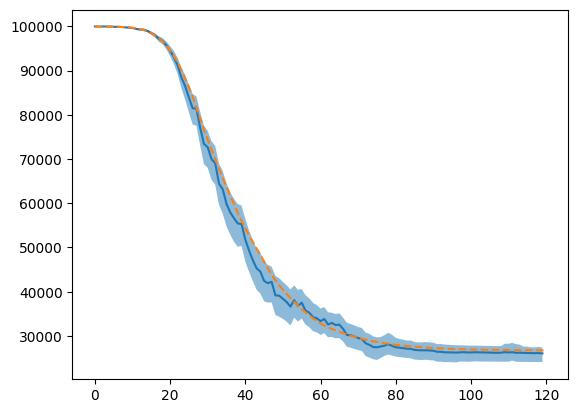

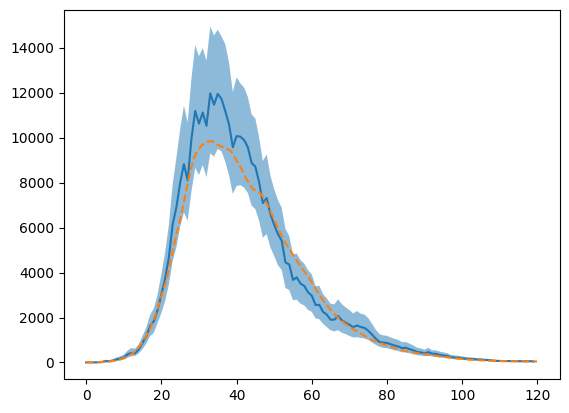

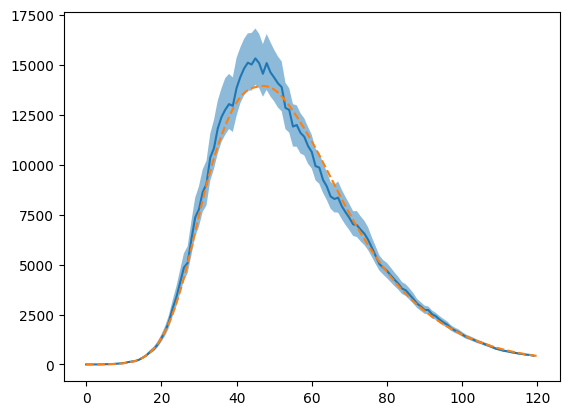

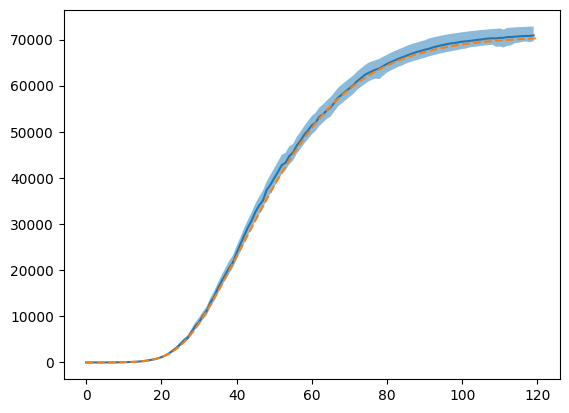

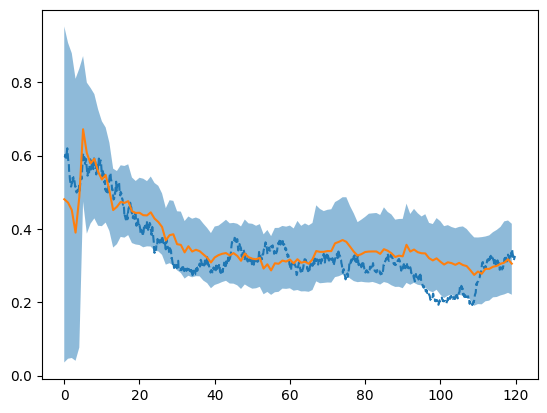

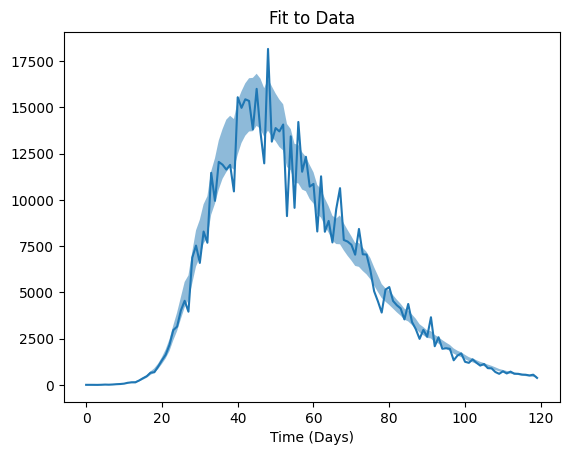

In [5]:
print(f" Log Likelihood : {np.sum(output['Log_likelihood'])}")

print(f"Root Mean Squared Error for the Data {np.sqrt(np.mean((data - np.mean(output['particle_observations'][:,0,:]))**2))}")

for i in range(4):
    plt.fill_between(t_vec[::int(1/dt)],np.percentile(output['particle_distribution'][:,i,:].T,5,axis = 1),np.percentile(output['particle_distribution'][:,i,:].T,95,axis = 1),alpha = 0.5)
    plt.plot(np.average(output['particle_distribution'][:,i,:],weights = np.exp(output['log_weights']),axis = 0))
    plt.plot(t_vec,state[i,:].T,'--')
    plt.show()

plt.plot(t_vec,betas,'--')
plt.fill_between(t_vec[::int(1/dt)],np.percentile(output['particle_distribution'][:,4,:].T,5,axis = 1),np.percentile(output['particle_distribution'][:,4,:].T,95,axis = 1),alpha = 0.5)
plt.plot(np.average(output['particle_distribution'][:,4,:],weights = np.exp(output['log_weights']),axis = 0))
plt.show()

plt.title("Fit to Data")
plt.xlabel('Time (Days)')
plt.plot(t_vec[::int(1/dt)],data.T)
plt.fill_between(t_vec[::int(1/dt)],np.percentile(output['particle_observations'][:,0,:].T,5,axis = 1),np.percentile(output['particle_observations'][:,0,:].T,95,axis = 1),alpha = 0.5)
plt.show()


In [6]:
pmcmc_rng = np.random.default_rng(0)

@nb.njit
def uniform_numba_logpdf(theta,min_val,max_val):

    if(theta < max_val and theta > min_val):
        return np.log(1/(max_val - min_val))
    
    return np.log(0.)

(gamma,sig,mean_ou,lam,1/R)

def seir_prior(theta):
    return uniform_numba_logpdf(theta[0],min_val= 1/28.,max_val= 1/7) + uniform_numba_logpdf(theta[1],min_val = 0.,max_val = 1.) + uniform_numba_logpdf(theta[2],min_val=-2,max_val=0.) + uniform_numba_logpdf(theta[3],min_val = 1/1000,max_val=1/2)


pmcmc_params = {'iterations':50_000,
                'init_params':np.array([0.1,0.1,-0.7,0.01,0.01]),
                'prior':seir_prior,
                'init_cov':  np.diag([0.01,0.01,0.01,0.01,0.01]),
                'burn_in':1_000}

pf_params = {'num_particles':1000, 
                      'dt':0.1,
                      'model':SEIR_model,
                      'observation_model':SEIR_Obs,
                      'model_dim':5,
                      'particle_initializer':SEIR_init
                      }

t = perf_counter()
pmcmc_output = particlemcmc(
                  data = data,
                  pmcmc_params=pmcmc_params,
                  pf_params=pf_params,
                  adaptive=True,
                  rng = rng,
                  req_jit=True
                  )
print(perf_counter() - t)


iteration: 10| Acceptance rate: 0.2| Log-Likelihood: -11165.923842634133| Proposal [ 0.08420432  0.02835682 -0.98225798  0.12148666  0.01618318]
iteration: 20| Acceptance rate: 0.1| Log-Likelihood: -11165.923842634133| Proposal [ 0.08420432  0.02835682 -0.98225798  0.12148666  0.01618318]
iteration: 30| Acceptance rate: 0.1| Log-Likelihood: -11072.91538636285| Proposal [ 0.06797006  0.11953067 -0.77424964  0.30597068  0.00567595]
iteration: 40| Acceptance rate: 0.1| Log-Likelihood: -10919.355557103505| Proposal [ 0.0699948   0.19702088 -0.80478166  0.16003899  0.10704943]
iteration: 50| Acceptance rate: 0.08| Log-Likelihood: -10919.355557103505| Proposal [ 0.0699948   0.19702088 -0.80478166  0.16003899  0.10704943]
iteration: 60| Acceptance rate: 0.08333333333333333| Log-Likelihood: -10909.405417912323| Proposal [ 0.06674784  0.38068914 -0.911138    0.28120513  0.07206658]
iteration: 70| Acceptance rate: 0.07142857142857142| Log-Likelihood: -10909.405417912323| Proposal [ 0.06674784  0

-10858.430218349851
The Maximum Likelihood Estimate is [ 0.07362342  0.14608916 -1.09395844  0.08291849  0.01756201] w/ LL of -10858.430218349851


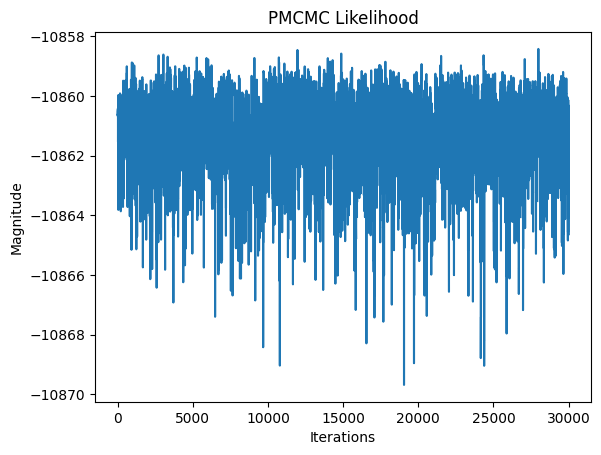

In [17]:
burn_in = 20000

MLE = np.argmax(pmcmc_output['Log Likelihood'])

print(pmcmc_output['Log Likelihood'][MLE])

print(f"The Maximum Likelihood Estimate is {pmcmc_output['accepted_params'][:,MLE]} w/ LL of {pmcmc_output['Log Likelihood'][MLE]}")

plt.title("PMCMC Likelihood")
plt.ylabel("Magnitude")
plt.xlabel("Iterations")
plt.plot(pmcmc_output['Log Likelihood'][burn_in:])

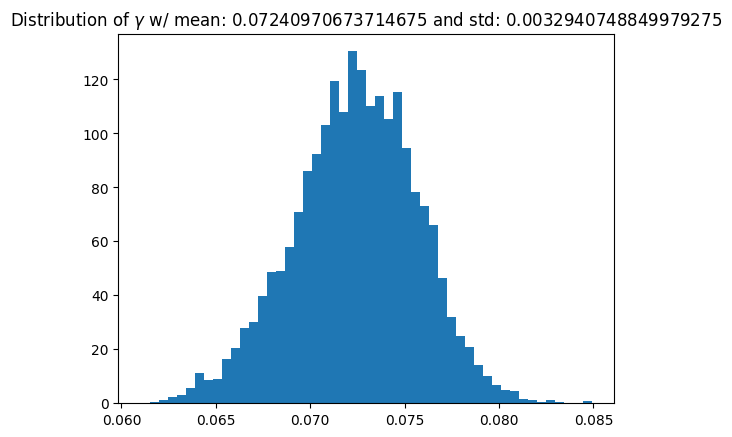

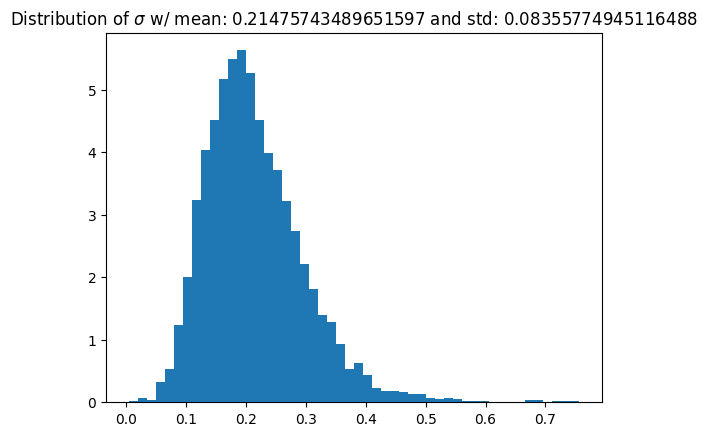

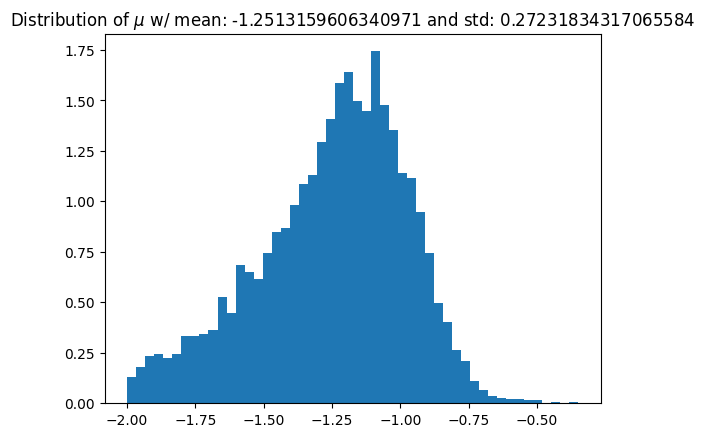

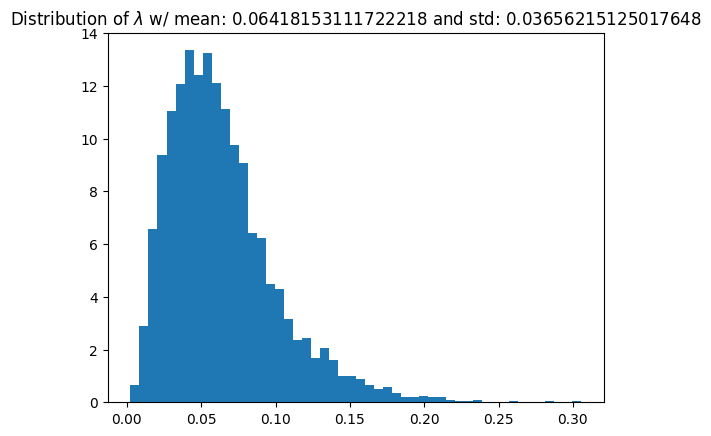

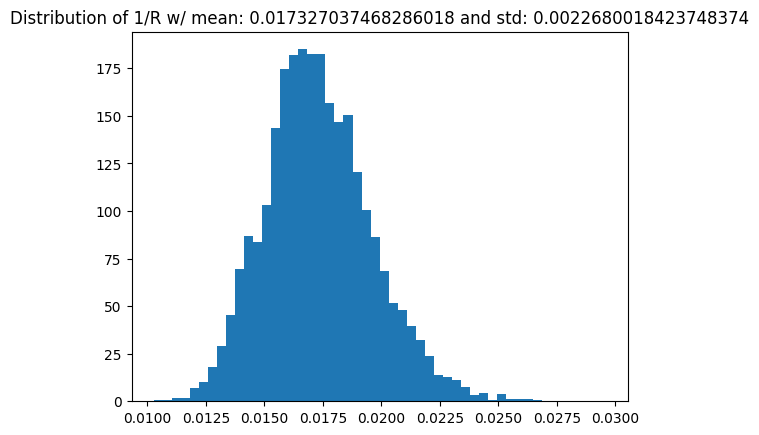

In [18]:
plt.title(f"Distribution of $\\gamma$ w/ mean: {np.mean(pmcmc_output['accepted_params'][0,burn_in:])} and std: {np.std(pmcmc_output['accepted_params'][0,burn_in:])}")
plt.hist(pmcmc_output['accepted_params'][0,burn_in:],density=True,bins = 50)
plt.show()

plt.title(f"Distribution of $\\sigma$ w/ mean: {np.mean((pmcmc_output['accepted_params'][1,burn_in:]))} and std: {np.std((pmcmc_output['accepted_params'][1,burn_in:]))}")
plt.hist((pmcmc_output['accepted_params'][1,burn_in:]),density=True,bins = 50)
plt.show()

plt.title(f"Distribution of $\\mu$ w/ mean: {np.mean((pmcmc_output['accepted_params'][2,burn_in:]))} and std: {np.std((pmcmc_output['accepted_params'][2,burn_in:]))}")
plt.hist((pmcmc_output['accepted_params'][2,burn_in:]),density=True,bins = 50)
plt.show()

plt.title(f"Distribution of $\\lambda$ w/ mean: {np.mean((pmcmc_output['accepted_params'][3,burn_in:]))} and std: {np.std((pmcmc_output['accepted_params'][3,burn_in:]))}")
plt.hist((pmcmc_output['accepted_params'][3,burn_in:]),density=True,bins = 50)
plt.show()

plt.title(f"Distribution of 1/R w/ mean: {np.mean((pmcmc_output['accepted_params'][4,burn_in:]))} and std: {np.std((pmcmc_output['accepted_params'][4,burn_in:]))}")
plt.hist((pmcmc_output['accepted_params'][4,burn_in:]),density=True,bins = 50)
plt.show()



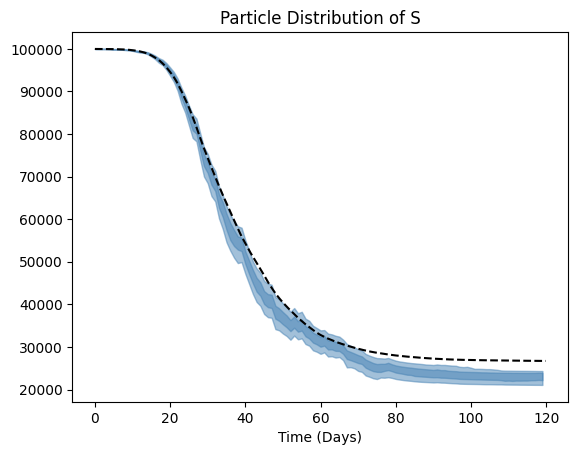

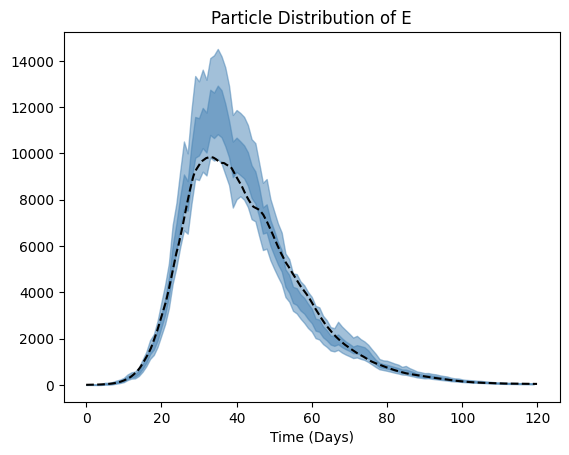

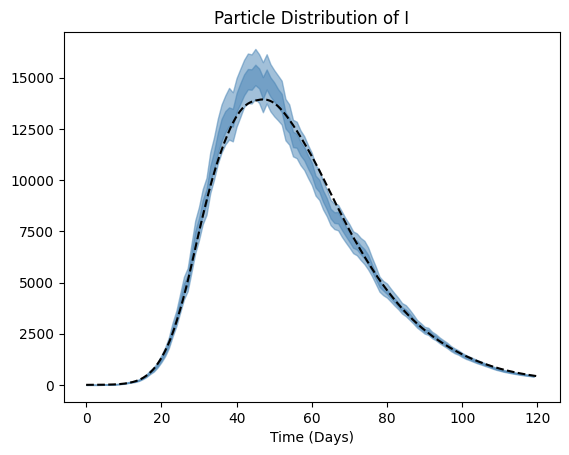

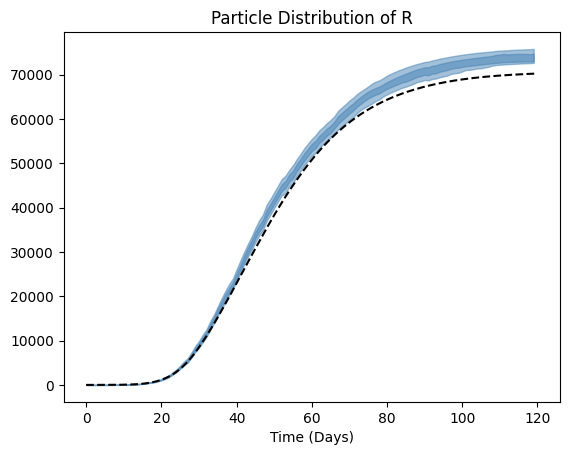

In [19]:
Labels = ['S','E','I','R']
for i in range(4):
    plt.title(f"Particle Distribution of {Labels[i]}")
    plt.xlabel('Time (Days)')
    plt.plot(t_vec,state[i,:].T,'--',color = 'black')
    #plt.plot(t_vec[::int(1/dt)],[i,:,MLE])
    plt.fill_between(t_vec[::int(1/dt)],np.percentile(pmcmc_output['MLE_particle_dist'][:,i,:].T,5,axis = 1),np.percentile(pmcmc_output['MLE_particle_dist'][:,i,:].T,95,axis = 1),alpha = 0.5,color = 'steelblue') 
    plt.fill_between(t_vec[::int(1/dt)],np.percentile(pmcmc_output['MLE_particle_dist'][:,i,:].T,25,axis = 1),np.percentile(pmcmc_output['MLE_particle_dist'][:,i,:].T,75,axis = 1),alpha = 0.5,color = 'steelblue') 
    plt.show()

Root Mean Squared Error for the Data 5026.622756209024
Root Mean Squared Error for beta 0.09944834272923211


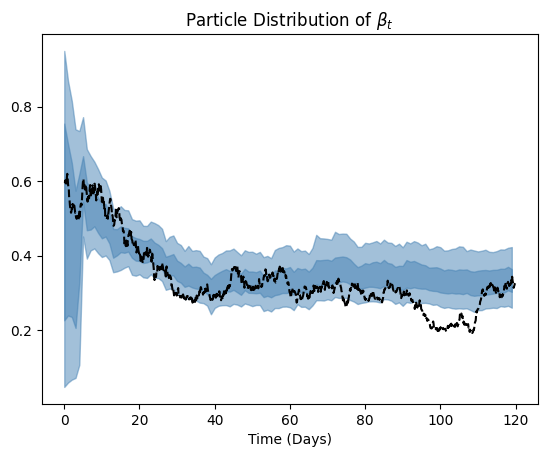

In [20]:
print(f"Root Mean Squared Error for the Data {np.sqrt(np.mean((data - np.mean(pmcmc_output['MLE_particle_observations'][:,0,:]))**2))}")
print(f"Root Mean Squared Error for beta {np.sqrt(np.mean((betas - np.mean(pmcmc_output['MLE_particle_dist'][:,4,:]))**2))}")
plt.title("Particle Distribution of $\\beta_t$")
plt.xlabel("Time (Days)")
plt.plot(t_vec,betas,'--',color = 'black')
plt.fill_between(t_vec[::int(1/dt)],np.percentile(pmcmc_output['MLE_particle_dist'][:,4,:].T,5,axis = 1),np.percentile(pmcmc_output['MLE_particle_dist'][:,4,:].T,95,axis = 1),alpha = 0.5,color = 'steelblue') 
plt.fill_between(t_vec[::int(1/dt)],np.percentile(pmcmc_output['MLE_particle_dist'][:,4,:].T,25,axis = 1),np.percentile(pmcmc_output['MLE_particle_dist'][:,4,:].T,75,axis = 1),alpha = 0.5,color = 'steelblue') 
plt.show()

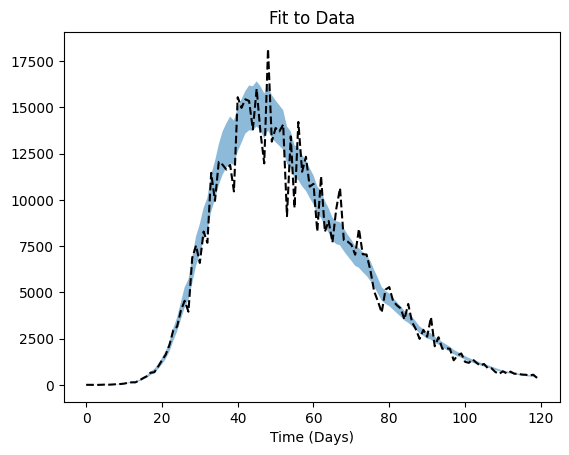

In [11]:
plt.title("Fit to Data")
plt.xlabel('Time (Days)')
plt.plot(t_vec[::int(1/dt)],data.T,'--',color = 'black')
plt.fill_between(t_vec[::int(1/dt)],np.percentile(pmcmc_output['MLE_particle_observations'][:,0,:].T,5,axis = 1),np.percentile(pmcmc_output['MLE_particle_observations'][:,0,:].T,95,axis = 1),alpha = 0.5)
plt.show()


In [12]:
import pickle

np.savez(f'../pmcmc_output/PMCMC.npz',distribution = pmcmc_output['MLE_particle_dist'], 
         observations = pmcmc_output['MLE_particle_observations'], 
         params = pmcmc_output['accepted_params'], 
         likelihood = pmcmc_output['Log Likelihood']
)

with open('../pmcmc_output/pmcmc_par.pickle', 'wb') as f:
    pickle.dump(pmcmc_params, f)
